# Predicting Coronary Artery Disease in Patients Undergoing Exercise Stress Tests and Angiography

## Introduction
The following dataset (www.kaggle.com/ronitf/heart-disease-uci) contains various measured parameters from patients undergoing angiography and exercise stress tests. Angigraphy is a clinical test used to visualize blood vessels in the body including the heart. In these patients, angiography was used to determine the narrowing of coronary arteries that supply blood to the cardiac muscle. Those with artery narrowing are deemed to have coronary artery disease (Detrano et. al.).
The purpose of this notebook is to take a closer look at this relatively small dataset and then establish a machine learning model that can correctly predict coronary artery disease (CAD). Predictions from such a model can then be corroborated with angiograms, if possible to do so in a timely manner so that an appropriate line of treatment can be initiated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

### Feature Description  

1) age  
2) sex (1 = male, 0 = female)  
3) cp -chest pain type (4 values: 0: asymptomatic, 1: atypical angina, 2: non-anginal pain, 3: typical angina)  
4) trestbps - resting blood pressure (mm Hg on admission to the hospital)  
5) chol - serum cholestoral in mg/dl  
6) fbs - fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)  
7) restecg - resting electrocardiographic results (value 0: showing probable or definite left ventricular hypertrophy by Estes’ criteria, Value 1: normal, value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))  
8) thalach - maximum heart rate achieved  
9) exang - exercise induced angina (1 = yes; 0 = no)  
10) oldpeak - ST depression induced by exercise relative to rest  
11) slope - the slope of the peak exercise ST segment  (0: downsloping; 1: flat; 2: upsloping)  
12) ca - number of major vessels (0-3) colored by flourosopy  
13) thal: A blood disorder called thalassemia Value 0: NULL (dropped from the dataset previously), Value 1: fixed defect (no blood flow in some part of the heart), Value 2: normal blood flow, Value 3: reversible defect (a blood flow is observed but it is not normal)  
14) Target - Coronary Artery Disease - CAD (0 = no, 1= yes)  

In [2]:
df1 = pd.read_csv('heart.csv')

In [3]:
df1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df1.shape #it is a pretty small dataset with only about 300 rows of patient data.

(303, 14)

In [5]:
df1.isnull().sum() #no null values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# EDA
### 1) Age distribution 

<AxesSubplot:xlabel='age', ylabel='Count'>

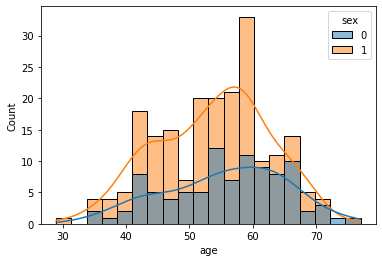

In [6]:
sns.histplot(x='age', hue='sex', data=df1, kde=True,bins=20)
#age distribution is similar for both genders. Greater proportion of patients are male

In [7]:
print('Mean age females :',df1[df1['sex']==0]['age'].mean())
print('Mean age males :',df1[df1['sex']==1]['age'].mean())
print('Number of females :', df1[df1['sex']==0]['age'].count())
print('Number of males :', df1[df1['sex']==1]['age'].count())

Mean age females : 55.677083333333336
Mean age males : 53.75845410628019
Number of females : 96
Number of males : 207


The age distribution is similar for males (mean age approx. 54 ys) and females (mean age approx 56 years) but a greater proportion, almost twice as many, of the patients in the dataset are males.

### 2) Blood pressure

In [8]:
df1[df1['target']==0]['trestbps'].mean()

134.3985507246377

In [9]:
df1[df1['target']==1]['trestbps'].mean()

129.3030303030303

Strangely, though it is considered a strong associated risk factor, the mean blood pressure is slightly lower in those diagnosed with CAD compared to those who were not. The mean blood pressure in both groups exceed 120 mm Hg and can be considered elevated. The histogram below illustrates blood pressure distribution in the patient groups.

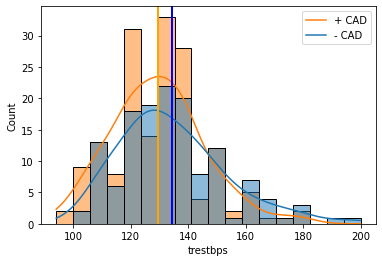

In [10]:
sns.histplot(x=df1['trestbps'], hue=df1['target'], kde=True)
plt.axvline(x=df1[df1['target']==0]['trestbps'].mean(), lw=2, c='b')
plt.axvline(x=df1[df1['target']==1]['trestbps'].mean(), lw=2, c='orange')
plt.legend(['+ CAD','- CAD'])

### 3) Correlation Heat Map

<AxesSubplot:>

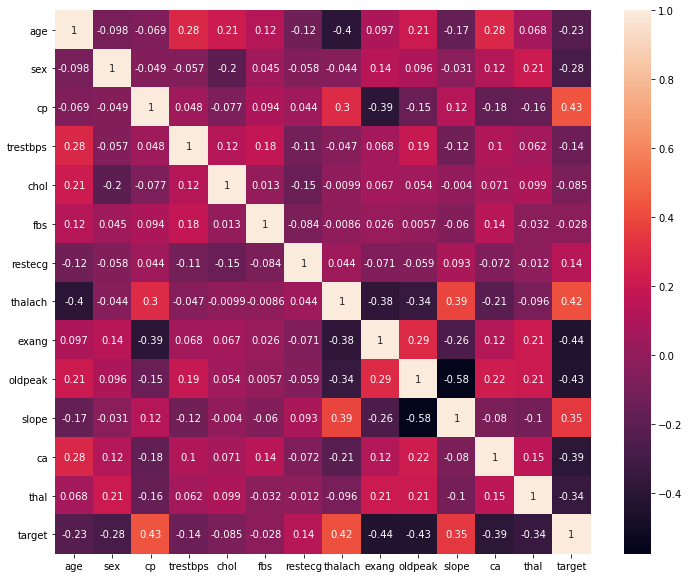

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(df1.corr(), annot=True)

There are no strong positive or negative correlations with within various features. The best positive correlations are between target and max heart rate achieved (thalarch) and chest pain type (cp). The strongest negative correlations are between target and exercise induced angina (exang) and ST segment depression due to exercise (oldpeak). Let's take a closer look at these features and how they may differ between the patient groups.

### 4) Maximum Heart Rate Achieved in Patients with CAD
Maximum heart rate during exercise is higher in patients with CAD compared to those without

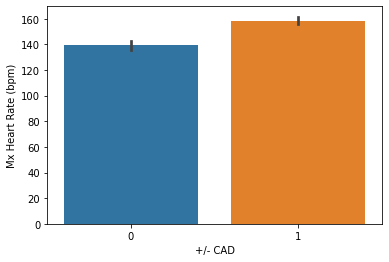

In [12]:
sns.barplot(y='thalach', x='target', data=df1)
plt.xlabel('+/- CAD')
plt.ylabel('Mx Heart Rate (bpm)')
plt.show()


### 5) Chest Pain Type Associated with CAD
Chest pain (angina) of all types is associated with the presence of CAD but less common in its absence.

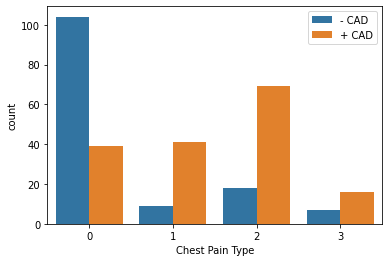

In [13]:
sns.countplot(x='cp', hue='target', data=df1)
plt.legend(['- CAD', '+ CAD'])
plt.xlabel('Chest Pain Type')
plt.show()

### 6) ECG Abnormalities Associated with CAD
During exercise testing, an upward ST slope is present in a large proportion of those with CAD. A downward slope is less commonly observed in those with CAD but more common in those without.

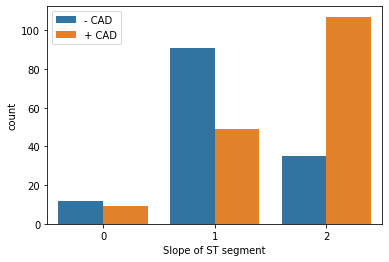

In [14]:
sns.countplot(x='slope', hue='target', data=df1)
plt.legend(['- CAD', '+ CAD'])
plt.xlabel('Slope of ST segment')
plt.show()

### 7) Serum Cholesterol Levels
Serum cholesterol is not very different between those with or without CAD. This is surprising since high cholesterol levels is strong risk factor for developing coronary artery disease. Since it is not clear what the bad cholesterol (LDL - low density lipoprotein) and good cholesterol (HDL - high density lipoprotein) levels are, we will assume that we cannot draw firm conclusions based on this data alone. It is however interesting to note is that the cholesterol levels are elevated in both groups. Ideal total cholesterol levels are 200 mg/dL or lower (https://www.healthline.com/health/high-cholesterol/levels-by-age). It is possible in the presence of elevated total serum cholesterol; some patients are more prone to developing CAD than others.

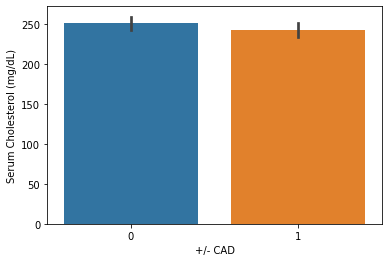

In [15]:
sns.barplot(y='chol', x='target', data=df1)
plt.xlabel('+/- CAD')
plt.ylabel('Serum Cholesterol (mg/dL)')
plt.show()

### 8) Number of Patients in Each Group
The patient groups are more or less balanced. Therefore we will proceed with the preparing the data for modeling.

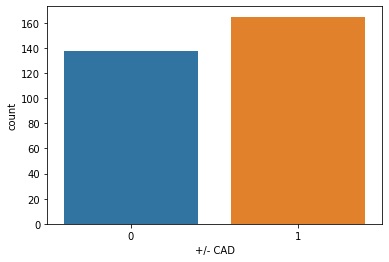

In [16]:
sns.countplot(x='target', data=df1)
plt.xlabel('+/- CAD')
plt.show()

# Data preprocessing
## 1) Create Dummy Columns

In [17]:
df1.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [18]:
dummy_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [19]:
df2 = pd.get_dummies(data = df1, columns = dummy_cols, drop_first =  True)

In [20]:
df2.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_1,cp_1,cp_2,cp_3,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


## 2) Train/test Split the Data

In [21]:
#define X and y
X = df2.drop('target', axis = 1)
y = df2['target']

In [22]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## 3) Scale the data

In [23]:
#scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Data Modeling
Models tested include Logistic Regression, Random Forest Classifier, Support Vector Machine, Gradient Boosting Classifier and XGBoost Classifier

In [24]:
model_logreg = LogisticRegression(max_iter=3500, C=1)
model_SVC=SVC(kernel='rbf', C=5, gamma='auto')
model_rfc=RandomForestClassifier(n_estimators=100, max_depth = 5)
model_gbc=GradientBoostingClassifier(learning_rate=0.1, max_depth=3)
model_xgb=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, learning_rate=0.5, max_depth=3)

#create a list of the model objects to be used in the for loop below
models=[model_logreg, model_SVC, model_rfc, model_gbc, model_xgb]

#an empty dictionary for storing average model metric data
score_dict = {'Logistic Regression':{},
              'Support Vector':{},
              'Random Forest':{},
              'Gradient Boost':{},
              'XG Boost':{}
             }

#following function inserts model metrics into the score_dict dictionary
def score_dict_edit (model):
    score_dict[model]['Model accuracy']=np.mean(accuracy_scores)
    score_dict[model]['CAD_precision']=np.mean(precision_scores)
    score_dict[model]['CAD_recall']=np.mean(recall_scores)
    score_dict[model]['CAD_F1']=np.mean(f1_scores)
    
    
    
for model in models: 
    #create empty lists to store the different testing metrics
    accuracy_scores =[]
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, predict))
    precision_scores.append(precision_score(y_test, predict, average=None)[1])
    recall_scores.append(recall_score(y_test, predict, average=None)[1])
    f1_scores.append(f1_score(y_test, predict, average=None)[1])
    

    if model==model_logreg:
        score_dict_edit ('Logistic Regression')
    elif model==model_SVC:
        score_dict_edit ('Support Vector')
    elif model==model_rfc:
        score_dict_edit ('Random Forest')
    elif model==model_gbc:
        score_dict_edit ('Gradient Boost')
    else:
        score_dict_edit ('XG Boost')
        
print('Following table summarizes the model accuracy and metrics for correctly classifying patients with CAD')
df_data=pd.DataFrame(score_dict).transpose()
df_data


Following table summarizes the model accuracy and metrics for correctly classifying patients with CAD


,Model accuracy,CAD_precision,CAD_recall,CAD_F1
Logistic Regression,0.819672,0.789474,0.909091,0.845070
Support Vector,0.786885,0.750000,0.909091,0.821918
Random Forest,0.770492,0.756757,0.848485,0.800000
Gradient Boost,0.754098,0.750000,0.818182,0.782609
XG Boost,0.754098,0.736842,0.848485,0.788732


All the models tested performed fairly well without hyperparameter tuning. Logistic regression and SVM, performed the best with impressive (~ 90%) recall scores for correctly classifying CAD class.

# Concluding Remarks
1) Despite the small size of the dataset, we were able to establish a machine learning model for predicting coronary artery disease (CAD) in patients using parameters (features) that can be easily determined in a hospital setting.  
2) Models using Logistic Regression or Support Vector Machine algorithms performed exceptionally well in predicting patients with CAD. Due to the satisfactory outcome, no effort was made to eliminate any of the features. As a matter of fact, other kagglers have noted that the model performances do not improve upon removing features, perhaps indicating that all the features play an important role in the models' predictive capabilities.  
3) Presence of other risk factors that can be associated with CAD include smoking, diabetes, obesity and family history of CAD. Inclusion of this information in the dataset may further improved the predictive capabilities of the model.

# Reference

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease, American Journal of Cardiology, 64,304-310.